Epoch 1/20


/home/professor/groundwaterprediction-LSTM/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1108
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1380
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1265
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1092
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1137
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0875
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0879
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1126
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1025
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1089
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0923
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0851
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1004
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0872
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1173
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/

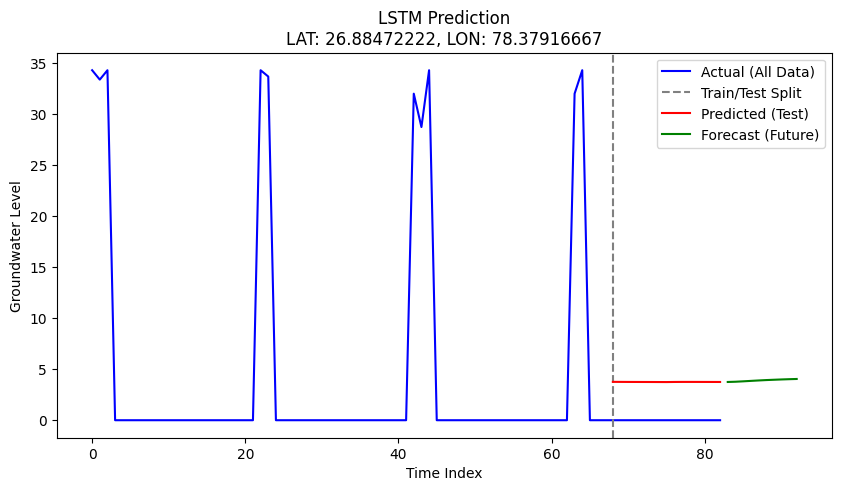


Future Groundwater Levels for LAT: 26.88472222, LON: 78.37916667
Future Step 1: 3.75
Future Step 2: 3.77
Future Step 3: 3.81
Future Step 4: 3.85
Future Step 5: 3.90
Future Step 6: 3.93
Future Step 7: 3.96
Future Step 8: 3.99
Future Step 9: 4.02
Future Step 10: 4.04


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

data = pd.read_csv("reshaped_groundwater_rainfall_data.csv")

def train_lstm_predict(
    data, 
    lat, 
    lon, 
    future_steps=4, 
    window_size=12, 
    epochs=20, 
    plot_results=True
):
    """
    Train an LSTM model on the time series of RAINFALL -> GROUNDWATER 
    for a particular (lat, lon), then:
      1) Predict on the test set (in-sample predictions)
      2) Forecast 'future_steps' steps beyond the training data (out-of-sample)
    
    Args:
        data (pd.DataFrame): DataFrame with columns ['LAT', 'LON', 'TIME', 'RAINFALL', 'GROUNDWATER']
        lat (float): Latitude to filter data
        lon (float): Longitude to filter data
        future_steps (int): Number of future steps to forecast
        window_size (int): Number of time steps used as input for each prediction
        epochs (int): Number of training epochs for the LSTM
        plot_results (bool): If True, plots actual vs. predicted data

    Returns:
        dict: A dictionary with:
          - 'model': The trained LSTM model
          - 'scaler_X': The fitted MinMaxScaler for X
          - 'scaler_y': The fitted MinMaxScaler for y
          - 'predictions_test': Model predictions on the test set (inverted scale)
          - 'y_test': True test targets (inverted scale)
          - 'future_predictions': Multi-step future forecasts (inverted scale)
    """
    # 1. Filter and sort data
    group = data[(data['LAT'] == lat) & (data['LON'] == lon)].sort_values(by='TIME')

    if group['RAINFALL'].isnull().all() or group['GROUNDWATER'].isnull().all():
        print(f"No valid data for LAT: {lat}, LON: {lon}. Skipping...")
        return None

    # 2. Prepare arrays for X and y
    X = group['RAINFALL'].fillna(0).values.reshape(-1, 1)
    y = group['GROUNDWATER'].fillna(0).values.reshape(-1, 1)

    if len(X) == 0 or len(y) == 0:
        print(f"Insufficient data for LAT: {lat}, LON: {lon}. Skipping...")
        return None

    # 3. Scale data (MinMaxScaler)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # 4. Create sequences
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window_size):
        X_seq.append(X_scaled[i : i + window_size])
        # The label is the next time step after the window
        y_seq.append(y_scaled[i + window_size])  

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    if X_seq.size == 0 or y_seq.size == 0:
        print(f"Not enough sequences for LAT: {lat}, LON: {lon}. Skipping...")
        return None

    # 5. Train/Test split
    split_index = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split_index], X_seq[split_index:]
    y_train, y_test = y_seq[:split_index], y_seq[split_index:]

    # 6. Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, verbose=1)

    # 7. In-sample predictions (Test set)
    if len(X_test) > 0:
        predictions_test = model.predict(X_test)
        predictions_test_inv = scaler_y.inverse_transform(predictions_test)
        y_test_inv = scaler_y.inverse_transform(y_test)
    else:
        predictions_test_inv = None
        y_test_inv = None

    # 8. Future forecasting
    future_predictions_scaled = []
    future_input = X_seq[-1].copy()  # last window from the training set

    for _ in range(future_steps):
        pred_scaled = model.predict(future_input.reshape(1, window_size, 1))
        future_predictions_scaled.append(pred_scaled[0, 0])
        
        # Shift window: drop first value, add new predicted value
        future_input = np.append(future_input[1:], pred_scaled).reshape(window_size, 1)

    # Invert scaling for future predictions
    future_predictions = scaler_y.inverse_transform(
        np.array(future_predictions_scaled).reshape(-1, 1)
    )

    # 9. (Optional) Plot Results
    if plot_results and predictions_test_inv is not None:
        plt.figure(figsize=(10, 5))
        
        # Plot historical actual
        plt.plot(range(len(y)), y, label='Actual (All Data)', c='blue')
        
        # Plot train/test boundary
        plt.axvline(split_index + window_size, color='gray', linestyle='--', label='Train/Test Split')

        # Plot test predictions
        test_indices = range(split_index + window_size, split_index + window_size + len(predictions_test_inv))
        plt.plot(test_indices, predictions_test_inv, label='Predicted (Test)', c='red')
        
        # Plot future predictions right after the last index of the dataset
        future_indices = range(len(y), len(y) + future_steps)
        plt.plot(future_indices, future_predictions, label='Forecast (Future)', c='green')
        
        plt.title(f"LSTM Prediction\nLAT: {lat}, LON: {lon}")
        plt.xlabel("Time Index")
        plt.ylabel("Groundwater Level")
        plt.legend()
        plt.show()

    # 10. Return results
    return {
        'model': model,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'predictions_test': predictions_test_inv,
        'y_test': y_test_inv,
        'future_predictions': future_predictions
}

# 11. User Input & Execution
if __name__ == "__main__":
    lat = float(input("Enter the latitude: "))
    lon = float(input("Enter the longitude: "))
    future_steps = int(input("Enter the number of future steps: "))

    results = train_lstm_predict(data, lat, lon, future_steps=future_steps)

    if results is not None and results['future_predictions'] is not None:
        future_values = results['future_predictions'].flatten()
        print(f"\nFuture Groundwater Levels for LAT: {lat}, LON: {lon}")
        for i, val in enumerate(future_values, start=1):
            print(f"Future Step {i}: {val:.2f}")
